In [1]:
import sys
import argparse
import os
import numpy as np
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate
import matplotlib.pyplot as plt
from scipy.stats import entropy
%matplotlib inline

Using TensorFlow backend.


# Data loading

In [2]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m test -d iq_data/CELL/anomal -w model/baseline".split()
namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')

In [3]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
train = namespace.mode == 'train'
reference_file_name = "reference_spectogram.pkl"

data_dir = namespace.data_dir

f_s = get_xhdr_sample_rate(data_dir)
t_s = 1/f_s
test_window_time = 10e-6

In [5]:
assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[-2]
if train:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_path = os.path.join(namespace.weights_path, weights_dir)
        fft_train = load_fft_train_data(data_dir, rbw, weights_path)

        fft_train = fft_train / fft_train.sum(axis=0, keepdims=1)
        persist_object(fft_train, os.path.join(weights_path, reference_file_name))

else:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_load_path = os.path.join(namespace.weights_path, weights_dir)
        freqs_test, time_test, fft_test = load_fft_test_data(data_dir, rbw, weights_load_path)

        fft_test = fft_test / fft_test.sum(axis=0, keepdims=1)
        fft_ref = load_object(os.path.join(weights_load_path, reference_file_name))

        # Define the windows size
        #         window_width = fft_test.shape[1]
        #         window_shape = (window_height , window_width)
        #         print(window_shape)

        # fft_test_windows = view_as_windows(fft_test,window_shape,step = window_height//2)

        divergences = np.zeros(fft_ref.shape[1])
        for i in range(len(divergences)):
            divergences[i] = entropy(fft_test[:,i], fft_ref[:, i])

In [ ]:
fig, ax = plt.subplots()
ax.imshow(fft_train, interpolation='nearest',aspect='auto',cmap='rainbow')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(40, 15))
ax.imshow(fft_test, interpolation='nearest',aspect='auto',cmap='rainbow')
plt.tight_layout()

In [ ]:
divergences.shape

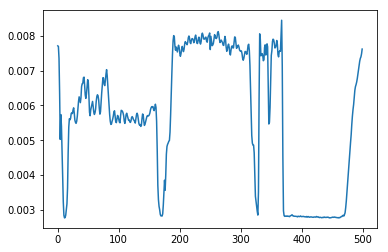

In [6]:
plt.plot(divergences)

In [ ]:
plt.imshow(fft_test,aspect='auto')

In [ ]:
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(fft_test.T, interpolation='nearest',aspect='auto',cmap='rainbow')
plt.tight_layout()

In [ ]:
spacing = np.diff(time_test)[0]

In [ ]:
spacing

In [ ]:
np.where()

In [ ]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [ ]:
outliers = outliers_iqr(divergences)

In [ ]:
outliers